In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from sklearn.model_selection import train_test_split

In [12]:
item = 'HousePrices' 
package = 'AER'

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

,price,lotsize,bedrooms,bathrooms,stories,driveway,recreation,fullbase,gasheat,aircon,garage,prefer
0,42000,5850,3,1,2,yes,no,yes,no,no,1,no
1,38500,4000,2,1,1,yes,no,no,no,no,0,no
2,49500,3060,3,1,1,yes,no,no,no,no,0,no
3,60500,6650,3,1,2,yes,yes,no,no,no,0,no
4,61000,6360,2,1,1,yes,no,no,no,no,0,no


In [14]:
df.shape

(546, 12)

In [16]:
df.isna().sum() ## наличие пропусков

price         0
lotsize       0
bedrooms      0
bathrooms     0
stories       0
driveway      0
recreation    0
fullbase      0
gasheat       0
aircon        0
garage        0
prefer        0
dtype: int64

In [18]:
df[df.duplicated()] ## наличие дубликатов строк

,price,lotsize,bedrooms,bathrooms,stories,driveway,recreation,fullbase,gasheat,aircon,garage,prefer
534,82000,5000,3,1,3,yes,no,no,no,yes,0,no


In [20]:
df = df.drop_duplicates()

In [22]:
df.shape ## результат очистки данных

(545, 12)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 0 to 545
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   price       545 non-null    int64 
 1   lotsize     545 non-null    int64 
 2   bedrooms    545 non-null    int64 
 3   bathrooms   545 non-null    int64 
 4   stories     545 non-null    int64 
 5   driveway    545 non-null    object
 6   recreation  545 non-null    object
 7   fullbase    545 non-null    object
 8   gasheat     545 non-null    object
 9   aircon      545 non-null    object
 10  garage      545 non-null    int64 
 11  prefer      545 non-null    object
dtypes: int64(6), object(6)
memory usage: 55.4+ KB


Проверили и очистили данные от пропусков и дубликатов. Данный датасет имел одну строку дублей, пропусков не обнаружено. Также установленно, что необходимости конвертации признаков нет.

## Проведем анализ влияния некоторых переменных на стоимость домов. Выбранный датасет описывает цены на дома, проданные в городе Виндзор, Канада, в июле, августе и сентябре 1987 года. Определим, есть ли статистически значимая зависимость между подъездными дорогами (driveway) и расположением дома в предпочтительном районе города (prefer). Н0 - нет статистической связи между двумя категориальными переменными. А также влияние одной из переменной, такой как aircon, на стоимость домов.

In [27]:
df['bedrooms'].value_counts()

bedrooms
3    300
2    136
4     95
5     10
1      2
6      2
Name: count, dtype: int64

In [29]:
df['price'].corr(df['bedrooms']) ## корреляция между ценой и количеством комнат в доме

0.3664940257738682

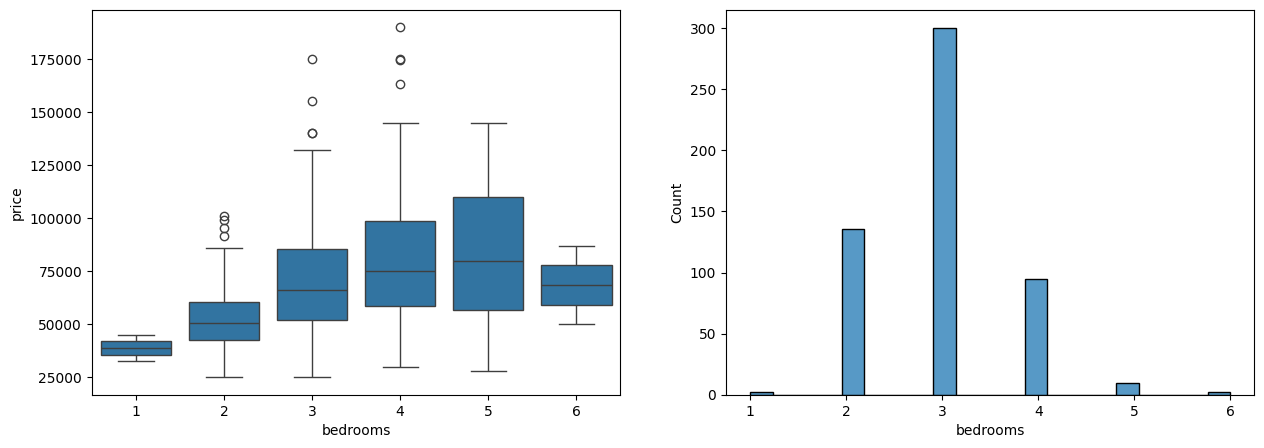

In [31]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.boxplot(data = df, x = 'bedrooms', y = 'price', ax = ax[0])
sns.histplot(data = df, x = 'bedrooms', ax = ax[1])
plt.show()

Проведем анализ взаимосвязи между двумя числовыми переменными. Определим, есть ли статистически значимая зависимость между ценой на дом (price) и количеством комнат в доме (bedrooms). Положительная корреляция, говорит нам о положительной взаимосвязи между переменными,т.е. чем больше комнат, тем больше цена. На основе сравнения бокс-плотов можно предположить, что между группами домов, распределенных по количеству комнат существует разница в цене. 1к-ые дома стоят соответственно меньше всего, 2к-ые, 3к-ые, 4к-ые имеют выбросы и не характерно высокие цены, самый большой "разброс" в цене и самую высокую стоимость (без учета выбросов 2,3,4 -х ) имеют 5к-ые домов, от 1-5 к мы наблюдаем характерный рост в цене, однако 6к-ые напротив имеют меньшую стоимость по отношению к 5-к домам.

Распределение переменной "количество комнат" далеко визуально от нормального. За указанный период больше всего продано 3-к домов.

In [33]:
stats.shapiro(df['bedrooms'])

ShapiroResult(statistic=0.8292241859985027, pvalue=1.1082903223666757e-23)

Нулевая гипотеза теста - данные распределены нормально

р-значение меньше 5% => данные противоречат нулевой гипотезе

Нулевая гипотеза отвергается, "количество комнат" распределены не по нормальному закону

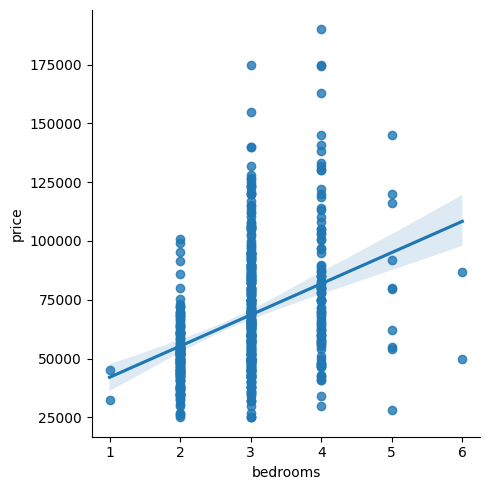

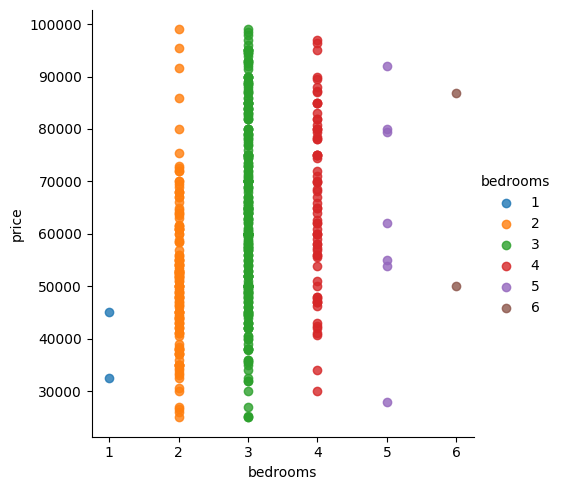

In [37]:
sns.lmplot(data = df, x = 'bedrooms', y = 'price') ##Регрессия
plt.show()
sns.lmplot(
    data = df[(df['bedrooms']<=6)&(df['bedrooms']>0)&(df['price']<100000)], 
    x = 'bedrooms', 
    y = 'price', 
    hue = 'bedrooms'
)
plt.show()

На первом графике видим, что есть выбросы по цене начиная со 125 000 долларов. Наилучшим образом прямая линия описывает взаимосвязь переменных, наибольшее количество показателей сконцентрированны в пределах до 100 000 долларов. Поэтому, ограничим наши данные (уберем выбросы) стоимостью домов 100 000 и построим 2 график.

In [40]:
df1k_price = df.loc[(df['bedrooms']==1)&(df['price']<100000), 'price']
df2k_price = df.loc[(df['bedrooms']==2)&(df['price']<100000), 'price']
df3k_price = df.loc[(df['bedrooms']==3)&(df['price']<100000), 'price']
df4k_price = df.loc[(df['bedrooms']==4)&(df['price']<100000), 'price']
df5k_price = df.loc[(df['bedrooms']==5)&(df['price']<100000), 'price']
df6k_price = df.loc[(df['bedrooms']==6)&(df['price']<100000), 'price']

In [42]:
##Определим среднюю стоимость домов за указанный период
print('Средняя цена 1к дома составляет', df1k_price.mean().round(2))
print('Средняя цена 2к дома составляет', df2k_price.mean().round(2))
print('Средняя цена 3к дома составляет', df3k_price.mean().round(2))
print('Средняя цена 4к дома составляет', df4k_price.mean().round(2))
print('Средняя цена 5к дома составляет', df5k_price.mean().round(2))
print('Средняя цена 6к дома составляет', df6k_price.mean().round(2))

Средняя цена 1к дома составляет 38750.0
Средняя цена 2к дома составляет 51522.22
Средняя цена 3к дома составляет 64062.74
Средняя цена 4к дома составляет 66209.86
Средняя цена 5к дома составляет 64342.86
Средняя цена 6к дома составляет 68450.0


In [44]:
stats.ttest_ind(df3k_price, df5k_price, alternative = 'two-sided')

TtestResult(statistic=-0.04124037030904686, pvalue=0.9671349768522174, df=268.0)

In [46]:
df1k = df.loc[df['bedrooms']==1, 'price']
df2k = df.loc[df['bedrooms']==2, 'price']
df3k = df.loc[df['bedrooms']==3, 'price']
df4k = df.loc[df['bedrooms']==4, 'price']
df5k = df.loc[df['bedrooms']==5, 'price']
df6k = df.loc[df['bedrooms']==6, 'price']

alpha = 0.95

mean_1k = df1k.mean()
var_1k = df1k.var()
n_1k = df1k.count()

ci_1k = stats.norm.interval(confidence = alpha, loc = mean_1k, scale = np.sqrt(var_1k/n_1k))
print(f'95% доверительный интервал для средней цены 1к домов от {ci_1k[0].round(2)} до {ci_1k[1].round(2)} долларов')

mean_2k = df2k.mean()
var_2k = df2k.var()
n_2k = df2k.count()
    
ci_2k = stats.norm.interval(confidence = alpha, loc = mean_2k, scale = np.sqrt(var_2k/n_2k))
print(f'95% доверительный интервал для средней цены 2к домов от {ci_2k[0].round(2)} до {ci_2k[1].round(2)} долларов')

mean_3k = df3k.mean()
var_3k = df3k.var()
n_3k = df3k.count()
        
ci_3k = stats.norm.interval(confidence = alpha, loc = mean_3k, scale = np.sqrt(var_3k/n_3k))
print(f'95% доверительный интервал для средней цены 3к домов от {ci_3k[0].round(2)} до {ci_3k[1].round(2)} долларов')

mean_4k = df4k.mean()
var_4k = df4k.var()
n_4k = df4k.count()

ci_4k = stats.norm.interval(confidence = alpha, loc = mean_4k, scale = np.sqrt(var_4k/n_4k))
print(f'95% доверительный интервал для средней цены 4к домов от {ci_4k[0].round(2)} до {ci_4k[1].round(2)} долларов')

mean_5k = df5k.mean()
var_5k = df5k.var()
n_5k = df5k.count()

ci_5k = stats.norm.interval(confidence = alpha, loc = mean_5k, scale = np.sqrt(var_5k/n_5k))
print(f'95% доверительный интервал для средней цены 5к домов от {ci_5k[0].round(2)} до {ci_5k[1].round(2)} долларов')

mean_6k = df6k.mean()
var_6k = df6k.var()
n_6k = df6k.count()
            
ci_6k = stats.norm.interval(confidence = alpha, loc = mean_6k, scale = np.sqrt(var_6k/n_6k))
print(f'95% доверительный интервал для средней цены 6к домов от {ci_6k[0].round(2)} до {ci_6k[1].round(2)} долларов')

95% доверительный интервал для средней цены 1к домов от 26500.23 до 50999.77 долларов
95% доверительный интервал для средней цены 2к домов от 49475.43 до 54296.63 долларов
95% доверительный интервал для средней цены 3к домов от 67955.01 до 73604.94 долларов
95% доверительный интервал для средней цены 4к домов от 75224.27 до 88483.1 долларов
95% доверительный интервал для средней цены 5к домов от 60983.96 до 105296.04 долларов
95% доверительный интервал для средней цены 6к домов от 32288.66 до 104611.34 долларов


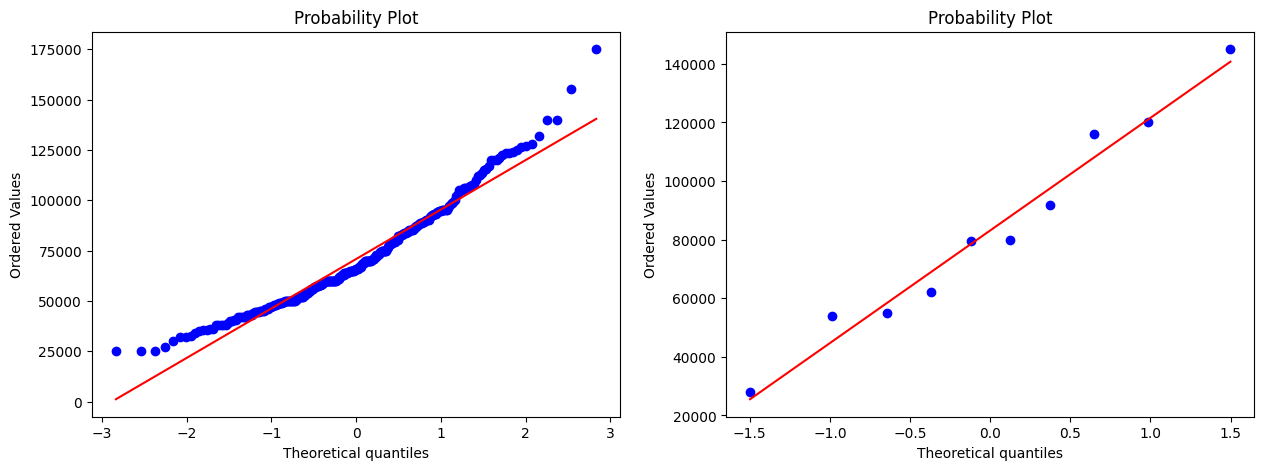

In [48]:
fig, ax  = plt.subplots(1,2, figsize = (15,5))
plt.title('QQ-plot для 3к и 5к домов')
stats.probplot(df3k, dist="norm", plot = ax[0])
stats.probplot(df5k, dist="norm", plot = ax[1])
plt.show()

In [50]:
## На графике видно, что распределение не совсем нармальное. От 125 000 это выбросы, поэтому ограничим наши данные этой стоимостью.
df3k_price = df.loc[(df['bedrooms']==3)&(df['price']<125000), 'price']
df5k_price = df.loc[(df['bedrooms']==5)&(df['price']<125000), 'price']

In [53]:
stats.mannwhitneyu(df3k_price, df5k_price, alternative = 'two-sided')

MannwhitneyuResult(statistic=1098.5, pvalue=0.4114385176108821)

Поскольку р-значение меньше 5%, нулевая гипотеза теста о том, что формы распределения цен на 3к дома и 5к дома совпадают (в т.ч., что совпадают их медианы), отвергается. Медианные цены на 3к и 5к квартиры не равны.

После проведенного выше анализа можно сказать, что статистическая зависимость между стоимостью домов и количеством комнат в них, существует. Несмотря на то, что гипотеза о равенстве средней цены между 3-к и 5-к домами нашла свое подтверждение, она может достигаться за счет количества проданных 3-к домов (300 ед), в то время как 5-х продано 10 ед, что также подтверждается медианным значением. Зависимость количества комнат и цены естественно должна существовать, ведь чем больше комнат, тем больше площадь дома и соответственно стоимость на его постройку возрастает, поэтому рост цены логичен, однако есть характеристики, которые не показаны в нашем датасете, такие как например состояние жилого помещение, что может удешевлять его стоимость, возможно по этой причине стоимость 6 комнатных домов не настолько велика по сравнению с другими.

In [56]:
 df.aircon

0       no
1       no
2       no
3       no
4       no
      ... 
541    yes
542    yes
543    yes
544    yes
545    yes
Name: aircon, Length: 545, dtype: object

In [58]:
df['aircon'].value_counts()

aircon
no     373
yes    172
Name: count, dtype: int64

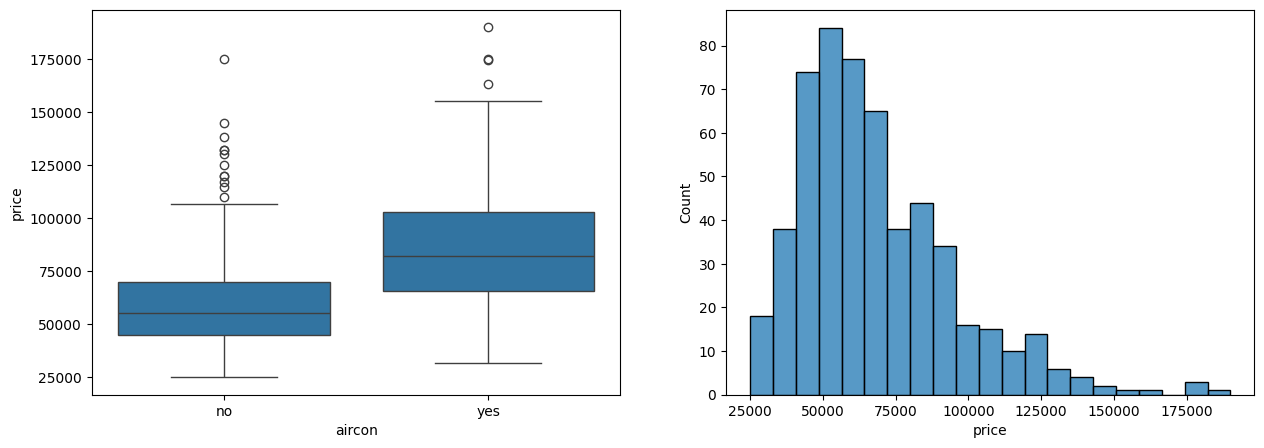

In [60]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.boxplot(data = df, x = 'aircon', y = 'price', ax = ax[0])
sns.histplot(data = df, x = 'price', ax = ax[1])
plt.show()

На основе сравнения бокс-плотов можно предположить, что между двумя переменными есть разница с точки зрения наличия системы кондиционирования в домах и их стоимостью. Визуально можно увидеть, что наличие системы кондиционированияимеется в 2к и 3к представлено в большей степени, чем в остальных. Распределение переменной bedrooms не нормальное.

In [62]:
stats.shapiro(df['price'])

ShapiroResult(statistic=0.9216311651574144, pvalue=3.1549030200516897e-16)

Нулевая гипотеза теста - медианное значение между двумя категориальными переменными не отличается

р-значение меньше 5% => данные противоречат нулевой гипотезе

Нулевая гипотеза отвергается, стоимость домов отличается от наличия системы кондиционирования в них.

## Для данного набора данных нашего датасета мы можем сформулировать задачу регрессии, целью которой будет предсказание цен на жилье (например, стоимость дома) на основе различных факторов, таких как площадь, количество комнат, расположение и другие характеристики. Эта задача имеет практическую ценность для агентов недвижимости, строительных компаний и покупателей, которые хотят обоснованно оценивать стоимость недвижимости.

## 1.Разделение датасета

## Мы будем разделять выборку на обучающую (60%), и тестовую (40%). Затем тестовая выборка будет разделена пополам (20% и 20%).

In [209]:
df['recreation'] = df['recreation'].replace({'yes': 1, 'no': 0})
df['driveway'] = df['driveway'].replace({'yes': 1, 'no': 0})
df['fullbase'] = df['fullbase'].replace({'yes': 1, 'no': 0})
df['gasheat'] = df['gasheat'].replace({'yes': 1, 'no': 0})
df['aircon'] = df['aircon'].replace({'yes': 1, 'no': 0})
df['prefer'] = df['prefer'].replace({'yes': 1, 'no': 0}) # заменили все значения "yes" и " no" на числовые переменны для дальнейшего исследования

In [211]:
df

,price,lotsize,bedrooms,bathrooms,stories,driveway,recreation,fullbase,gasheat,aircon,garage,prefer
0,42000,5850,3,1,2,1,0,1,0,0,1,0
1,38500,4000,2,1,1,1,0,0,0,0,0,0
2,49500,3060,3,1,1,1,0,0,0,0,0,0
3,60500,6650,3,1,2,1,1,0,0,0,0,0
4,61000,6360,2,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
541,91500,4800,3,2,4,1,1,0,0,1,0,0
542,94000,6000,3,2,4,1,0,0,0,1,0,0
543,103000,6000,3,2,4,1,1,0,0,1,1,0
544,105000,6000,3,2,2,1,1,0,0,1,1,0


In [213]:
cat_vars = ['driveway', 'recreation', 'fullbase', 'gasheat', 'aircon', 'prefer' ]
num_vars = ['lotsize', 'bedrooms', 'bathrooms', 'stories', 'garage']
target_var = ['price']

In [215]:
X_dummies = pd.get_dummies(df[cat_vars], drop_first = True, dtype = int)
X_dummies.head()

,driveway,recreation,fullbase,gasheat,aircon,prefer
0,1,0,1,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,1,0,0,0,0
4,1,0,0,0,0,0


In [217]:
X = df[num_vars]
X = pd.merge(
    left = X,
    right = X_dummies,
    how = 'inner',
    left_index = True,
    right_index = True
)

y = df[target_var]

In [219]:
X

,lotsize,bedrooms,bathrooms,stories,garage,driveway,recreation,fullbase,gasheat,aircon,prefer
0,5850,3,1,2,1,1,0,1,0,0,0
1,4000,2,1,1,0,1,0,0,0,0,0
2,3060,3,1,1,0,1,0,0,0,0,0
3,6650,3,1,2,0,1,1,0,0,0,0
4,6360,2,1,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
541,4800,3,2,4,0,1,1,0,0,1,0
542,6000,3,2,4,0,1,0,0,0,1,0
543,6000,3,2,4,1,1,1,0,0,1,0
544,6000,3,2,2,1,1,1,0,0,1,0


In [221]:
target = 'price'  # price наша целевая переменная
features = df.columns[df.columns != target]

In [223]:
# Разделение на обучающую и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(df[features], df[target], test_size=0.4, random_state=42)

In [225]:
X_train.shape

(327, 11)

In [227]:
X_temp.shape

(218, 11)

In [229]:
# Разделение тестовой выборки на две половины
X_val, X_forecast, y_val, y_forecast = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [231]:
X_val.shape

(109, 11)

In [233]:
X_forecast.shape

(109, 11)

In [311]:
# Вывод форм размерностей выборок
print("Размер обучающей выборки:", X_train.shape, y_train.shape)
print("Размер валидационной выборки:", X_val.shape, y_val.shape)
print("Размер выборки для прогнозирования:", X_forecast.shape)

Размер обучающей выборки: (327, 11) (327,)
Размер валидационной выборки: (109, 11) (109,)
Размер выборки для прогнозирования: (109, 11)


## 2. Обучение моделей и оценка качества.

Этот процесс позволит нам получить представление о предсказаниях цен на жилье. 

In [237]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [239]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [247]:
y_pred = ols.predict(X_temp)

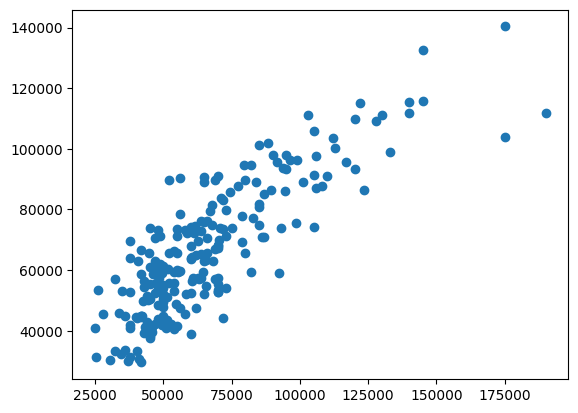

In [253]:
plt.scatter(y_temp, y_pred)
plt.show()

In [ ]:
## Будем использовать следующие метрики качества модели регрессии: R2, MAE, MAPE, RMSE.

In [255]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_temp, y_pred))
print('MAE', mean_absolute_error(y_temp, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_temp, y_pred)))
print('MAPE', mean_absolute_percentage_error(y_temp, y_pred))

R2 0.695139507735769
MAE 11469.288790989865
RMSE 15498.110758751054
MAPE 0.18416697019652556


In [332]:
df[target_var].mean()

price    68096.13211
dtype: float64

Выводы после получения данных обученной модели LinearRegression: изучив диаграмму распределения, мы можем сказать, что предсказанные значения Y достаточно близки к фактическим значениям Y.  R2 - точность предсказанной модели (69,51%) достаточно высокая, MAPE - % ошибки (18,41%) достаточно низкий. 

# 3. На основе второй половины тестовой выборки сделаем предсказание целевой переменной.

In [356]:
# Подготовка и масштабирование второй половины тестовой выборки
X_forecast_scaled = scaler.transform(X_forecast)

In [358]:
# Обучение модели Linear Regression 
best_model = LinearRegression()  
best_model.fit(X_train_scaled, y_train)

LinearRegression()

In [362]:
# Предсказание на второй половине выборки
y_forecast_pred = best_model.predict(X_forecast_scaled)
print("Предсказанные значения цен на недвижимость:", y_forecast_pred)

Предсказанные значения цен на недвижимость: [ 60057.23070747  71230.38472975  78526.31239423  53474.2557908
  90813.64153624  86560.32652321  61865.31935388  49555.2626372
  52000.74979729  87165.74437473  89000.00269409  50373.26953238
  41364.71518551  59081.68767711  66153.92066088  73614.24606823
  56956.15718917  74397.26209372  39476.8305823   45984.6674111
  42988.05544116  52159.61087159  93272.99089435  41752.8389118
  56393.6586399  111682.23588581  87818.01109249  57524.23399558
  59432.03239374  40878.50647387  30587.35810763  91380.94258165
  50588.45614943  67415.08499483  63513.43109608  79867.78589524
  33649.62974794  69945.00337808 101378.12184124  44487.76291477
  50163.02352675  57478.55680991 132702.62891755  45642.50860491
  89106.72841671  85984.71884222  57484.82236044  93596.85529407
  74961.88759971  95756.07529471  52902.41857012  73727.71197178
  74069.63868029  73254.95614243  65544.81453775  69549.11555686
  54279.63408841  65496.01647364  47580.03974617  

In [364]:
# Можем использовать предсказанные значения как средние для принятия решений
mean_predicted = np.mean(y_forecast_pred)
print("Средняя предсказанная цена:", mean_predicted)

Средняя предсказанная цена: 66819.86831773198


In [366]:
# Рекомендации по преобретению недвижимости
for i, predicted_price in enumerate(y_forecast_pred):
    if predicted_price < mean_predicted:
        print(f"Экземпляр {i+1}: Предполагаемая цена {predicted_price:.2f}. Рекомендуем рассмотреть данный экземпляр, так как цена ниже средней.")
    else:
        print(f"Экземпляр {i+1}: Предполагаемая цена {predicted_price:.2f}. Цену можно считать выше средней, стоит учесть дополнительные факторы.")

Экземпляр 1: Предполагаемая цена 60057.23. Рекомендуем рассмотреть данный экземпляр, так как цена ниже средней.
Экземпляр 2: Предполагаемая цена 71230.38. Цену можно считать выше средней, стоит учесть дополнительные факторы.
Экземпляр 3: Предполагаемая цена 78526.31. Цену можно считать выше средней, стоит учесть дополнительные факторы.
Экземпляр 4: Предполагаемая цена 53474.26. Рекомендуем рассмотреть данный экземпляр, так как цена ниже средней.
Экземпляр 5: Предполагаемая цена 90813.64. Цену можно считать выше средней, стоит учесть дополнительные факторы.
Экземпляр 6: Предполагаемая цена 86560.33. Цену можно считать выше средней, стоит учесть дополнительные факторы.
Экземпляр 7: Предполагаемая цена 61865.32. Рекомендуем рассмотреть данный экземпляр, так как цена ниже средней.
Экземпляр 8: Предполагаемая цена 49555.26. Рекомендуем рассмотреть данный экземпляр, так как цена ниже средней.
Экземпляр 9: Предполагаемая цена 52000.75. Рекомендуем рассмотреть данный экземпляр, так как цена ни

Проходимся по предсказанным значениям и выдаем рекомендации для каждого экземпляра: если предсказываемая цена ниже среднего значения, мы рекомендуем обратить внимание на эту недвижимость, так как цена ниже средней; в противном случае мы сообщаем, что стоимость может быть выше средней, и стоит рассмотреть дополнительные факторы. 
Таким образом,можнот использовать эти рекомендации как часть анализа рынка недвижимости.

Итак, проведя анализ по заданному датасету, можно сделать следующие выводы: стоимость домов возрастает от количества комнат в них, наличие подъездных путей к домовладениям зависит от расположения в предпочтительном районе города, система кондиционирования отличается в домах и повышает стоимость жилья. Большим спросом пользуются 3-к дома за 3 месяца их продано 300 ед., средняя стоимость которых составила 64062.74 долларов, меньшим - 1к (средняя стоимость 38750.0 долларов) и 6к (средняя стоимость 68450.0) дома их продано по 2 ед.
Для данного датасета мы сформулировали задачу регрессии, целью которой было предсказание цен на жилье на основе различных факторов, таких как площадь, количество комнат, расположение и другие характеристики. 
График рассеяния, который мы получили в процессе обучения модели линейной регрессии (LinearRegression) позволил визуально оценить, насколько точно модель предсказывает целевую переменную. На графике видно, что и моделпрактически точноно предсказывает значения, все точкпрактическиут располаютсяся на диагонали, проходящей через начало координат (линии 45 градусов), чтможет т означать, что предсказанные значения равны истинным значения 
а
Анализ факторов, влияющих на е по По данным модели можно выделить важные характеристики, которые повышают или понижают стоимостьлья, о.
итьенка инвестиционной привлекатость. пи: Потенциальные покупатели могут использовать эту информацию для принятия обоснованных решений о покупке недвостиж си.
Создание улучшенных пложенло, на основе которых аий: Агенты могут предлагать индивидуализированные рекомендации для клиентов на основе их предпочтений и рыночанныхных д. 
С помпроведенного анализа мыовмыыемможме не только построить модель, но и подготовить полное обоснование для практического применения в области недвиимостижимости.